# 파이썬 웹  크롤링 & 텍스트 분석

## 11. 한국어 감성분석 맛보기
- 네이버 영화 리뷰 데이터 불러오기 및 전처리하기
- 영화 리뷰로 감성 사전 만들어보기(긍정/부정 단어)
- 각 단어의 긍정/부정 점수 계산 및 시각화하기

### 리뷰 데이터 불러오기
- Dataset source: https://github.com/e9t/nsmc

In [1]:
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from konlpy.tag import Twitter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

In [2]:
df = pd.read_table("ratings.txt")
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [3]:
twitter = Twitter()

In [4]:
# 첫 번째 영화 리뷰 프로세싱
twitter.morphs(df["document"][0])

['어릴', '때', '보고', '지금', '다시', '봐', '도', '재밌어', '요', 'ㅋㅋ']

In [ ]:
# 데이터가 너무 많아 오래걸릴 수 있으니 일부만 취사선택(optional)
df = df.iloc[:10000]

In [5]:
%%time
reviews = []              # 토큰화한 리뷰를 담기 위한 리스트
labels = []               # 각 리뷰의 라벨(긍정/부정)을 담기 위한 리스트
all_tokens = []           # 모든 토큰을 담기 위한 리스트
unique_tokens = dict()    # 유니크한 토큰만 담기 위한 셋

for i in range(len(df)):
    try:
        tokens = twitter.morphs(df["document"][i])
        reviews.append(tokens)
        labels.append(df["label"][i])
        
        all_tokens += tokens
        for t in tokens:
            if t in unique_tokens.keys():
                unique_tokens[t] += 1
            else:
                unique_tokens[t] = 1
    except:
        pass
    
print("Number of Reviews: ", len(reviews), len(labels))
print("Number of tokens: ", len(all_tokens))
print("Number of unique tokens: ", len(unique_tokens))

Number of Reviews:  199991 199991
Number of tokens:  3272356
Number of unique tokens:  70195
Wall time: 3min 18s


In [6]:
### token_to_idx: 토큰(key) -> 인덱스(value)
### idx_to_token: 인덱스(key) -> 토큰(value)
def create_dictionary(unique_tokens, threshold):
    token_to_idx = dict()
    idx_to_token = dict()
    unique_token_keys = list(unique_tokens.keys())
    
    j = 0
    for i in range(len(unique_token_keys)):
        if unique_tokens[unique_token_keys[i]] > threshold:
            token_to_idx[unique_token_keys[i]] = j
            idx_to_token[j] = unique_token_keys[i]
            j += 1
    
    return token_to_idx, idx_to_token

In [7]:
token_to_idx, idx_to_token = create_dictionary(unique_tokens, 500)

print(len(token_to_idx), len(idx_to_token))

789 789


In [8]:
%%time
# 각 리뷰의 토큰을 인덱스로 변경한다
for i in range(len(reviews)):
    for j in range(len(reviews[i])):
        if reviews[i][j] in token_to_idx.keys():
            reviews[i][j] = token_to_idx[reviews[i][j]]
        else:
            reviews[i][j] = None
            
    reviews[i] = [x for x in reviews[i] if x != None]

Wall time: 1.7 s


In [11]:
i = 0
for r in reviews:
    if len(r)!=0:
        i += 1
        
print("Number of non-empty reviews: ", i)

Number of non-empty reviews:  197022


In [12]:
for i in range(len(reviews)):
    if len(reviews[i]) == 0:
        reviews[i], labels[i] = None, None

reviews = [x for x in reviews if x != None]
labels = [x for x in labels if x != None]

print(len(reviews), len(labels))

197022 197022


### 영화 리뷰로 감성 사전 만들어보기(긍정/부정 단어)

In [13]:
# 리뷰의 모든 토큰을 긍정 토큰/부정 토큰으로 구분지어 본다
pos_tokens, neg_tokens = [], []

for i in range(len(labels)):
    if labels[i] == 1:
        for tk in reviews[i]:
            pos_tokens.append(tk)
    else:
        for tk in reviews[i]:
            neg_tokens.append(tk)

In [14]:
pos_cnt = Counter(pos_tokens)
neg_cnt = Counter(neg_tokens)

pos_words, neg_words = set(), set()

In [15]:
# 긍정 토큰 중 가장 많이 등장하는 200개 토큰만 출력
for idx, count in pos_cnt.most_common(200):
    word = idx_to_token[idx]
    pos_words.add(word)
    print(word, ": ", count)

. :  45726
이 :  39944
영화 :  35330
다 :  33176
의 :  25434
을 :  21676
에 :  19042
가 :  18660
.. :  16911
도 :  16406
는 :  15474
은 :  13005
들 :  12930
... :  12300
요 :  12201
, :  11780
좋 :  11769
를 :  11046
고 :  10866
한 :  10151
봤 :  9050
너무 :  8665
정말 :  8603
! :  8307
게 :  8291
적 :  7545
최고 :  7442
것 :  6723
지 :  6570
서 :  6153
수 :  6050
는데 :  5899
음 :  5848
나 :  5804
과 :  5534
만 :  5528
진짜 :  5458
습니다 :  5457
보고 :  5453
~ :  5421
감동 :  5155
있 :  5111
내 :  5061
연기 :  5054
에서 :  5038
으로 :  4984
거 :  4720
잘 :  4534
로 :  4517
던 :  4496
와 :  4471
어요 :  4412
인 :  4323
? :  4129
그 :  4113
봐 :  4021
점 :  4015
드라마 :  4010
!! :  3835
데 :  3817
았 :  3779
지만 :  3763
때 :  3755
아 :  3738
이다 :  3722
네요 :  3710
평점 :  3614
본 :  3589
ㅋㅋ :  3387
하고 :  3327
이런 :  3275
듯 :  3253
다시 :  3249
사람 :  3230
네 :  3129
안 :  3129
더 :  3105
였 :  3090
10 :  3079
볼 :  3072
중 :  3066
했 :  2973
있는 :  2866
니다 :  2855
라 :  2819
배우 :  2770
보다 :  2762
말 :  2732
하는 :  2731
.... :  2665
보는 :  2613
면 :  2577
입니 :  2574
못 :  2528


In [16]:
# 부정 토큰 중 가장 많이 등장하는 200개 토큰만 출력
for idx, count in neg_cnt.most_common(200):
    word = idx_to_token[idx]
    neg_words.add(word)
    print(word, ": ", count)

. :  45977
이 :  40387
다 :  34432
영화 :  33427
가 :  24226
.. :  21772
도 :  20544
는 :  19217
... :  18258
에 :  18197
을 :  17630
의 :  16607
은 :  14920
들 :  13921
고 :  12210
, :  11801
한 :  11118
를 :  11088
? :  10664
게 :  9910
만 :  9038
지 :  8951
나 :  8861
거 :  7548
너무 :  6891
것 :  6781
서 :  6595
로 :  6301
요 :  6215
음 :  6041
진짜 :  5828
내 :  5737
으로 :  5652
안 :  5575
점 :  5559
는데 :  5320
아 :  5284
1 :  5229
봤 :  4980
못 :  4966
평점 :  4936
이런 :  4720
데 :  4710
적 :  4705
네 :  4661
스토리 :  4563
재미없 :  4540
왜 :  4447
정말 :  4405
쓰레기 :  4382
에서 :  4380
좋 :  4346
라 :  4299
.... :  4204
아니 :  4199
뭐 :  4090
그냥 :  4011
없는 :  3976
하는 :  3940
하고 :  3898
인 :  3865
듯 :  3821
말 :  3771
감독 :  3764
보다 :  3763
시간 :  3741
연기 :  3725
내용 :  3615
했 :  3580
수 :  3567
과 :  3401
그 :  3363
보고 :  3347
와 :  3295
이다 :  3285
보는 :  3267
사람 :  3258
면 :  3254
좀 :  3232
없다 :  3212
재미 :  3207
겠 :  3083
아깝 :  3023
배우 :  3008
최악 :  3001
! :  2959
~ :  2953
이건 :  2866
더 :  2852
야 :  2848
까지 :  2752
있 :  2723
할 :  2710
드라마 :  26

In [17]:
# 긍정 토큰, 부정 토큰, 중립 토큰 세 가지로 나눈다
# 여기서 토큰을 살펴보고 적절하지 않거나 의미 없는 토큰을 제외할 수 있다
print("Common words: ", pos_words.intersection(neg_words))
print("Only Positive: ", pos_words - neg_words)
print("Only Negative: ", neg_words - pos_words)

Common words:  {'데', '으면', '아', '좀', '점', '난', '던', '스토리', '보는', '임', '하는', '는데', '중', '!!', '더', '네요', '습니다', '저', '주', '?', '마지막', '나', '지', '..', '만', '2', '의', '본', '는', '네', '액션', '없다', '인', '정도', '1', '10', '봐', '것', '연기', '니다', '잘', '평점', '적', 'ㅋㅋㅋ', '하고', '!', '인데', '그냥', '이다', '했', '까지', '할', '참', '도', '보면', '안', '되', '하나', '다는', '못', '았', '감독', '아니', '사람', '싶', '겠', '과', '좋', '내', '니', '요', '알', '지만', '3', '이렇게', '에서', '가', '들', '정말', '어', '....', '까', '너무', 'ㅋ', '으로', '말', '로', '라', '하', '있는', '된', '고', '생각', '영화', '장면', '~', '였', '때', '이야기', '있', '게', '왜', '음', '진짜', '보고', '처음', '느낌', '그', '볼', '드라마', '거', '서', '감동', '에', '를', 'ㅋㅋ', '이', '이런', '.', '와', '없는', '야', '함', '시간', '한', '건', ',', '작품', "'", '을', '줄', '다', '수', '은', '...', '보다', '배우', '내용', '같은', '봤', '완전', '듯', '재미', '면'}
Only Positive:  {'굿', '대박', '꼭', '입니', '아이', '같다', '살', '지금', 'ㅎㅎ', '두', '인생', '매력', '또', '여운', '짱', '재밌었', '사랑', '한번', '하게', '~~', '재밌게', '었', '명작', '년', '이고', '에게', '기억', '최고', '가장', '마음', '재밌다

In [18]:
# 나만의 감정 분석기(분류기)를 만들어 본다
def my_sentiment_classifier(sentence):
    only_pos = pos_words - neg_words
    only_neg = neg_words - pos_words
    
    pos_score, neg_score = 0, 0
    for idx in sentence:
        if idx_to_token[idx] in only_pos:
            pos_score += 1
        elif idx_to_token[idx] in only_neg:
            neg_score += 1
        
    if pos_score >= neg_score:
        return 1
    else:
        return 0

In [19]:
y_classified = []

for sentence in reviews:
    y_classified.append(my_sentiment_classifier(sentence))

In [20]:
### 내가 만든 분석기의 정확도를 출력해 본다.
### 모두 맞춘 경우 정확도가 1.0, 모두 틀릴 경우 0.0이다
print("Accuracy: ", accuracy_score(labels, y_classified))

Accuracy:  0.671595050299


### 각 단어의 긍정/부정 점수 계산 및 시각화하기

In [22]:
# 모든 유니크한 토큰을 모아본다
all_tokens = pos_tokens + neg_tokens
all_counts = Counter(all_tokens)

In [23]:
scores = dict()
for idx, cnt in all_counts.most_common(500):
    scores[idx] = [0, 0]

In [24]:
for i in range(len(reviews)):
    if labels[i] == 0:
        for idx in reviews[i]:
            if idx in scores.keys():
                scores[idx][0] += 1
    else:
        for idx in reviews[i]:
            if idx in scores.keys():
                scores[idx][1] += 1

In [32]:
token_scores = pd.DataFrame(scores).T

In [33]:
tokens = []
for i in token_scores.index:
    tokens.append(idx_to_token[i])

In [34]:
# 이제는 자주 등장하는 각 토큰의 부정/긍정 점수를 계산해본다
token_scores.index = tokens
token_scores.columns = ["neg_score", "pos_score"]
token_scores

,neg_score,pos_score
때,1951,3755
보고,3347,5453
지금,930,2199
다시,723,3249
봐,2289,4021
도,20544,16406
재밌어,145,1397
요,6215,12201
ㅋㅋ,2322,3387
을,17630,21676


In [35]:
# 감성 지수를 반영한 두 번째 감성분석기(분류기)를 만들어본다
def my_second_sentiment_classifier(sentence):
    pos_score, neg_score = 0, 0
    for idx in sentence:
        token = idx_to_token[idx]
        if token in token_scores.index:
            pos_score += token_scores.loc[token][1]
            neg_score += token_scores.loc[token][0]
            
    if pos_score >= neg_score:
        return 1
    else:
        return 0

In [36]:
y_classified = []

for sentence in reviews:
    y_classified.append(my_second_sentiment_classifier(sentence))    

In [37]:
print("Accuracy: ", accuracy_score(labels, y_classified))

Accuracy:  0.690430510298


### 감성 지수 시각화

In [28]:
# 시각화를 위해 일부 데이터만 활용해본다
token_scores = token_scores[np.logical_and(\
                                np.logical_and(token_scores["neg_score"] > 1000, \
                                           token_scores["neg_score"] < 2000), \
                                np.logical_and(token_scores["pos_score"] > 1000, \
                                           token_scores["pos_score"] < 2000))]

In [29]:
colors = []

for i in range(len(token_scores)):
    if token_scores["neg_score"].iloc[i] / token_scores["pos_score"].iloc[i] > 1:
        colors.append("#fc2647")
    else:
        colors.append("#056eee")

In [30]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

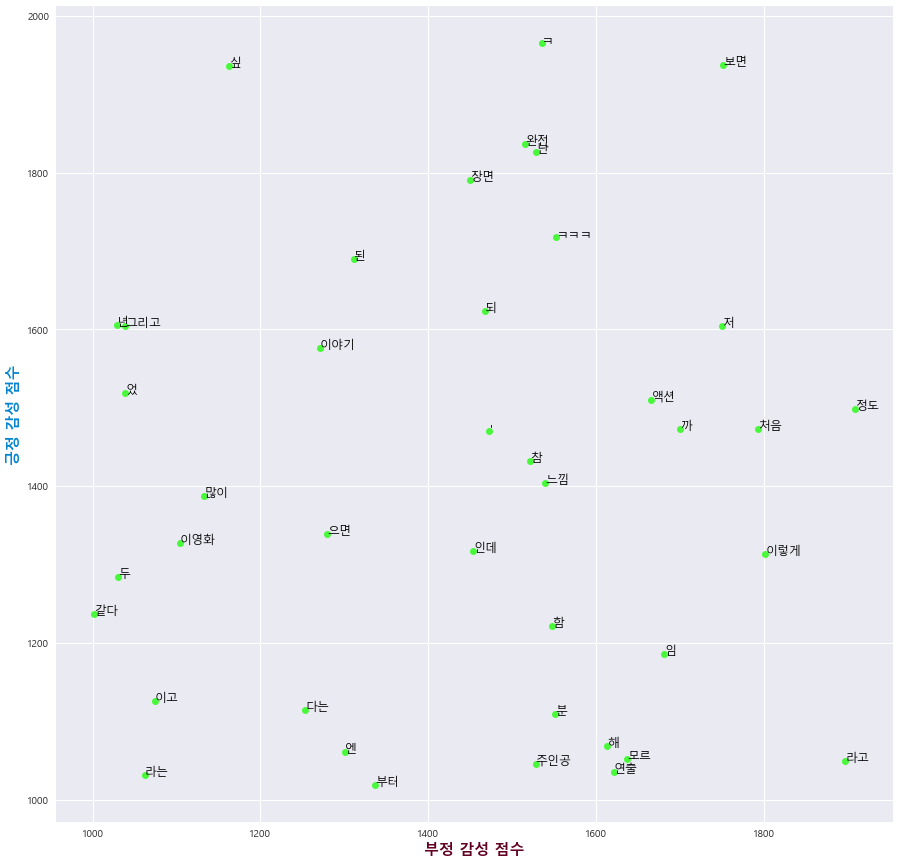

In [31]:
plt.rcParams["figure.figsize"] = (15,15)
plot = seaborn.regplot(x="neg_score", y= "pos_score", color = "#21fc0d", \
                        data = token_scores,fit_reg = False)

for i in range(len(token_scores)):
    plot.text(token_scores.neg_score[i] + 0.2, token_scores.pos_score[i] - 0.2, token_scores.index[i], \
              size = "medium", horizontalalignment = "left", color="black")
plt.xlabel("부정 감성 점수", fontsize = 15, fontweight = "bold", color = "#610023")
plt.ylabel("긍정 감성 점수", fontsize = 15, fontweight = "bold", color = "#0485d1")
plt.show()